# SPASE Record Analysis - How to Use (Advanced)
Author: Zach Boquet

## Introduction 
For documentation on how to add to this project, view the related notebook named "HowToAdd.ipynb" <br>
<br>
This project provides a method to analyze FAIR for the SPASE records in the NumericalData and DisplayData categories.<br>

This notebook shows you how to convert desired SPASE record fields into a SQLite database. The desired fields correspond to metadata extracted from XML files using ElementTree. Also shown is how to query data from that database. <br> 
- The tutorial I used to implement ElementTree is <a href="https://realpython.com/python-xml-parser/" target="_blank">https://realpython.com/python-xml-parser/</a>. 
- If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">https://www.sqlitetutorial.net/</a>.<br>

*Note that this code was extensively tested on the NASA SPASE Github repo. However, results are not guaranteed when running on other SPASE Github repos. This code was tested in Summer 2024 on SPASE version 2.6.1*

This program takes ~3.88 minutes (233 seconds) to fully run from scratch on over 3000 records.

This program takes ~1.28 minutes (77 seconds) to update over 3000 records if using built-in database.

You can also run the program using older database files found in the repo history. Simply change the name of the parameter to the create_sqlite_database function in the first cell to the name of the .db file you wish to use.

In [1]:
# clone NASA SPASE Github Repo into the directory above this tutorial.
! git clone -b master --single-branch --depth=1 https://github.com/hpde/NASA ../../NASA

fatal: destination path '../../NASA' already exists and is not an empty directory.


In [2]:
# show your current directory
! pwd

/home/jovyan/HDRL-Internship-2024/Tutorials


## Scraping the SPASE records and populating our tables

This code block performs the following: <br>

- takes the absolute path of a SPASE directory they wish to be scraped as an argument<br>
- finds all desired metadata <br>
- creates all needed tables <br>
- adds an entry for each record found into the MetadataEntries table. <br>
- stores the locations of where each metadata field is found in the MetadataSources table <br>
- adds entries into the Records table with general info and info needed for database maintenance.<br>
- populate the TestResults table with default values. <br>
- update the columns associated with a given analysis test (i.e records that have authors -> has_author column) to have a 'True' value of 1.<br>
<br>

If you want a full printout of everything being done, pass True as the printFlag argument to Create.<br>

Examples are also found as comments at the bottom of the code block to test smaller, yet complex directories.<br>
Note: This code was designed to work for the NumericalData and DisplayData directories, so inputting directories besides those two may cause logical errors and produce unintended results.

### Starting from an Existing Database
A pre-built database is included in this repository. You can use this database as a starting point if you would like to see how the project updates the tables.

If you wish to start completely from scratch, skip this section and refer to the next section.

*Note that running the project from the built-in database is much faster than creating your own from scratch*

In [3]:
from Scripts import create_sqlite_database

help(create_sqlite_database)

Help on function create_sqlite_database in module Scripts.SQLiteFun:

create_sqlite_database(filename)
    Creates a database connection to a new or existing SQLite database with
    the name provided. If the database already exists, it returns
    a connection object. This also tells you any errors that may occur.
    
    :param filename: String that contains the desired name of the database
    :type filename: String
    :return: Connection object



In [4]:
# input abs path of database file you wish to load from, located one directory above this notebook
#conn = create_sqlite_database("../SPASE_Data_20240716.db")

### Creating or Updating a Database
If updating the built-in database, skip the first cell which overrides the conn variable and run the other cells. Otherwise, if you wish to start completely from scratch, run all cells.

#### Example directories
 
Overall paths (>3000 records): "../../NASA/NumericalData" and "../../NASA/DisplayData"  
Smaller subdirectory = "../../NASA/NumericalData/DE2"   
Bigger subdirectory = "../../NASA/NumericalData/ACE"  
Complex author examples: "../../NASA/NumericalData/Cassini/MAG/PT60S.xml" and "../../NASA/NumericalData/ACE/Attitude/Definitive/PT1H.xml"  
Complex URL example: "../../NASA/NumericalData/ACE/CRIS/L2/P1D.xml"  
#### Code

In [5]:
#from Scripts import create_sqlite_database

# if you wish to start a fresh db file from scratch
conn = create_sqlite_database("../SPASE_Data_new.db")

In [6]:
# import main Python function
from Scripts import Create

help(Create)

Help on function Create in module Scripts.main:

Create(folder, conn, printFlag=False)
    Scrapes all records that are found in the directory given
    for the desired metadata. Creates the MetadataEntries,
    MetadataSources, Records, and TestResults tables and populates
    them using the data scraped for each record. Populates the
    TestResult table with default values to be overwritten by
    the call to the FAIRScorer function in the notebook.
    
    :param folder: The absolute file path of the SPASE record/directory
                        containing the record(s) the user wants scraped.
    :type folder: String
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param printFlag: A boolean determining if the user wants to print
                        more details of what the function is doing.
    :type printFlag: Boolean
    :return: None



In [7]:
# This block updates current records from the indicated directories in the MetadataEntries table
# This step can take a while if you start with a new database file.
# Starting with an existing database file significantly speeds this up.
Create('../../NASA/NumericalData', conn)
Create('../../NASA/DisplayData', conn)

You entered ../../NASA/NumericalData
Discovering SPASE records....
The number of records is 2850
Metadata extraction complete.                        
TestResult entries completedfor record 2847 of 2850
Metadata successfully stored in the SQL tables.
You entered ../../NASA/DisplayData
Discovering SPASE records....
The number of records is 187
Metadata extraction complete.                        
TestResult entries completedfor record 186 of 187
Metadata successfully stored in the SQL tables.


These few lines simply connect to a new database file and update the database using the SPASE records in the desired directory.

## Executing Analysis Tests and Viewing the Results 
In this code block, we perform calls to the View function in main to get the Counts and ID's of the SPASE records that pass each analysis test. 
These analysis tests include links that have: <br> 

- authors <br>
- publishers <br>
- publication years <br>
- dataset names <br>
- licenses <br>
- URLs <br>
- NASA URLs <br>
- persistent identifiers <br>
- descriptions <br>
- citation info <br>
- DCAT-3 compliance info.<br>

### Executing the Analysis Tests

In [8]:
# this function returns all records that pass associated tests 
# and prints the counts of those that pass the test specified in the argument
from Scripts import View

help(View)

Help on function View in module Scripts.main:

View(conn, All=True, desired=['all', 'Author', 'Publisher', 'Publication Year', 'Dataset Name', 'CC0 License', 'URL', 'NASA URL', 'Persistent Identifier', 'Description', 'Citation', 'DCAT3-US Compliance'], print_flag=True)
    Prints the number of records that meet each test criteria
    provided as well as return those SPASE_id's to the caller
    in the form of a dictionary. The keys are the Strings passed
    as parameters and the values are the list of SPASE_id's
    that fulfill that test.
    
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param All: A boolean determining if the records returned will be from
                the set containing all records present in the database or
                only those with NASA URLs.
    :type All: Boolean
    :param desired: A list of Strings which determine the kind of records
                    whose counts are printed and whose SPASE_id's are
 

In [9]:
# example that returns values for one test
records = View(conn, desired = ['Citation'])

There are 1883 records with citation info.
There are 3033 records total.


In [10]:
# example that returns values for 4 tests, one of which doesn't match
records = View(conn, desired = ['Author', 'Publisher', 'NASA URL', 'Compliance'])

There are 2906 records with an author.
There are 3033 records with a publisher.
There are 2253 records with a NASA URL.
Requested field Compliance not found. Please choose from ['Author', 'Publisher', 'NASA URL', 'Compliance', 'all']
There are 3033 records total.


In [11]:
# example that returns values for all tests
records = View(conn)

There are 3033 records total.
There are 2906 records with an author.
There are 3033 records with a publisher.
There are 1883 records with a publication year.
There are 3033 records with a dataset.
There are 0 records with a CC0 license.
There are 3033 records with a URL.
There are 2253 records with a NASA URL.
There are 1863 records with a persistent identifier.
There are 3033 records with a description.
There are 1883 records with citation info.
There are 1863 records that meet DCAT3-US compliance.


### Plotting the Analysis Results

In [12]:
# This function creates a bar chart for the metadata fields checked.
from Scripts import MetadataBarChart

help(MetadataBarChart)

Help on function MetadataBarChart in module Scripts.PlotScripts:

MetadataBarChart(conn, percent=False, All=True)
    Takes a connection object as parameter as well as a dictionary
    containing the SPASE records with each kind of metadata. It
    iterates through the values of the dictionary to get the counts
    of these records. It then uses this to display a bar chart showing
    the number of records that have each kind of metadata field. This
    does so by using NumPy arrays within a MatPlotLib function. The
    default value for the percent parameter is False, which means the
    chart displayed will show the data labels as integers. If True,
    the data labels are displayed as percentages. The default value
    for All is True, which means that it uses all records in the database
    as data for the chart. Passing False to the All parameter performs
    the same, but only the records with NASA URLs are used for the chart.
    
    :param conn: A connection to the desired dat

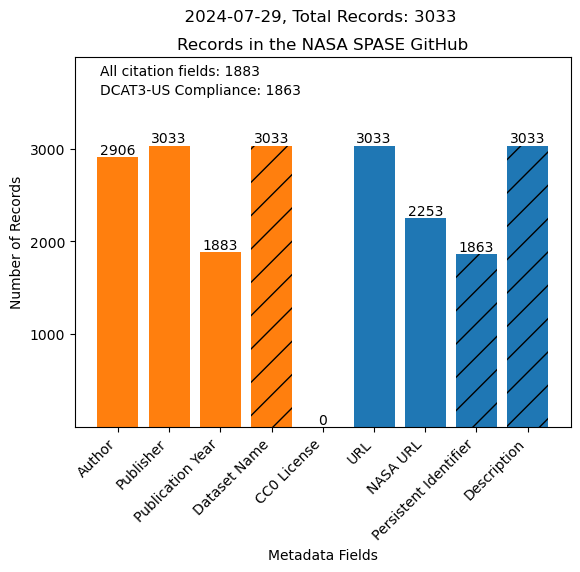

In [13]:
# Plotting the bar chart for all records 
fig = MetadataBarChart(conn)

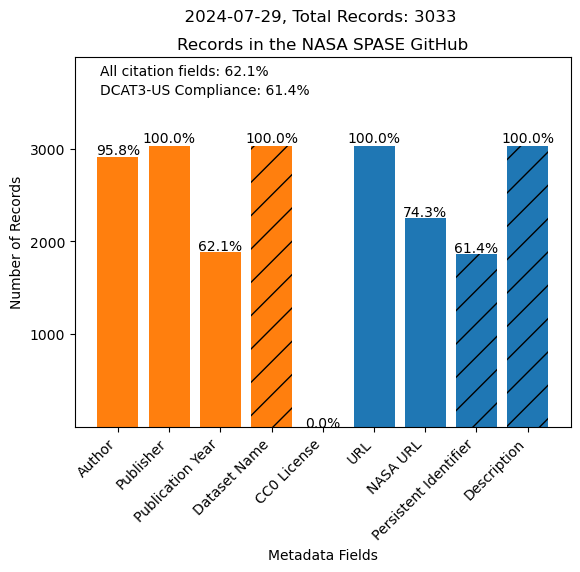

In [14]:
# Plotting the percent version of the same bar chart
fig = MetadataBarChart(conn, percent = True)

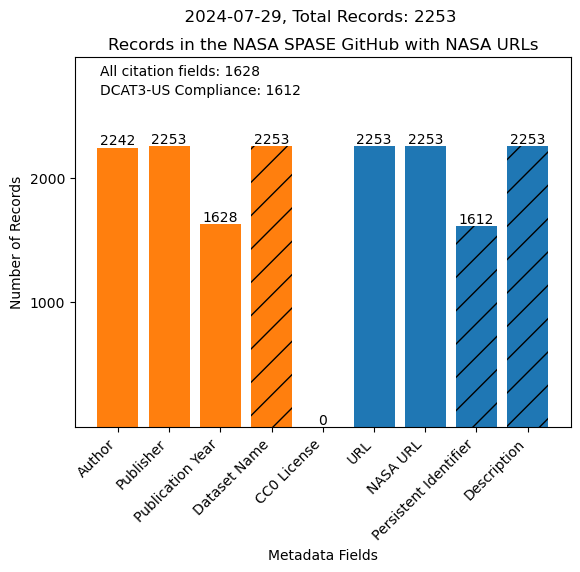

In [15]:
# Plotting the bar chart for only records with a NASA URL
fig = MetadataBarChart(conn, All = False)

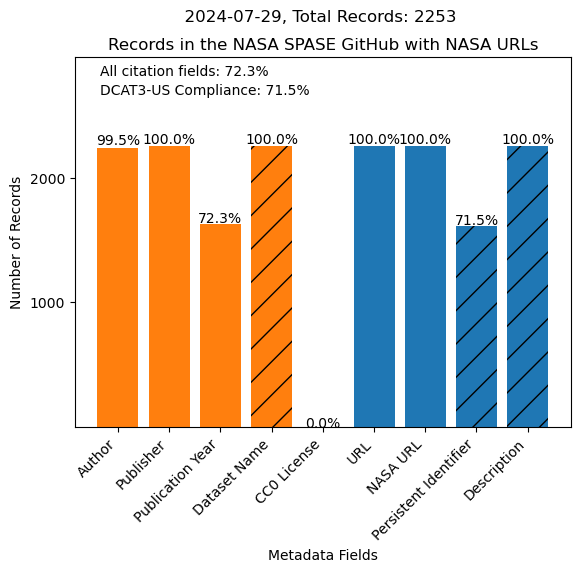

In [16]:
# Plotting the percent version of the same bar chart
fig = MetadataBarChart(conn, percent = True, All = False)

## Calculating and plotting the FAIR Score Distributions
This code overwrites the default values placed in the TestResults table to have the actual FAIR Scores that are calculated according to the following algorithm:<br>

- +1 for author
- +1 for dataset name
- +1 for publication year
- +1 for publisher
- +1 for all citation info
- +1 for description
- +1 for PID
- +1 for DCAT3-US compliance
- +1 for license
- +1 for NASA URL <br>
======================= <br>
- Total Possible Points of 10

*Note that this alogrithm is expected to change*

If interested in viewing the FAIR Score for a particular record, refer to the column-specific queries section further below.  

### Calculating the FAIR Scores
These code blocks will be much faster if simply updating the already populated database. Otherwise, it will take longer.

In [17]:
from Scripts import FAIRScorer

help(FAIRScorer)

Help on function FAIRScorer in module Scripts.SQLiteFun:

FAIRScorer(conn)
    Iterates through the has_x column names of the TestResults table
    to calculate the FAIR Score of all the records in the parameter.
    FAIR Score is calculated according to the algorithm described in
    the notebook. Once the FAIR score is calculated, the FAIR_Score,
    MostRecent, and FAIR_ScoreDate columns are updated for that record.
    
    :param conn: A connection to the desired database
    :type conn: Connection object
    :return: None



In [18]:
# calculate FAIR scores for all records
FAIRScorer(conn)

Analyzing 3033 records found
FAIR scores calculated. Use the View function to see the results.


### Plotting the FAIR Score Distributions

In [19]:
from Scripts import FAIR_Chart

help(FAIR_Chart)

Help on function FAIR_Chart in module Scripts.PlotScripts:

FAIR_Chart(conn, All=True)
    Executes a SQLite SELECT statement to collect all FAIR Scores
    and displays a bar chart showing the number of records for each
    FAIR Score. This does so by using NumPy arrays within a MatPlotLib
    function. The default value for All is True, which uses data from
    all the records in the database. Passing False to the All parameter
    performs the same, but only for the records with NASA URLs.
    
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param All: A boolean determining whether or not to use all records
                    in the database or only those with NASA URLs.
    :type All: Boolean
    :return: the figure



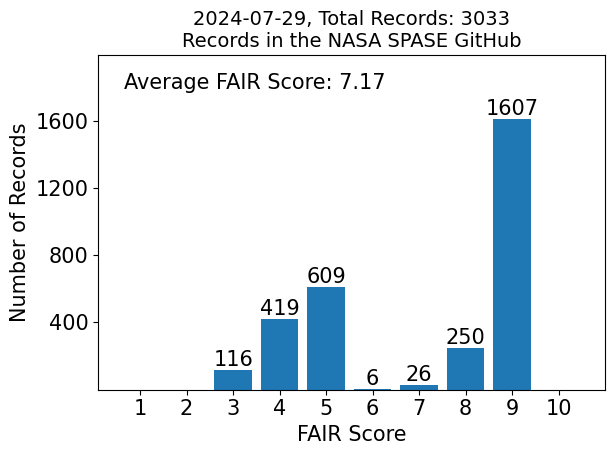

In [20]:
# for all records
fig = FAIR_Chart(conn)

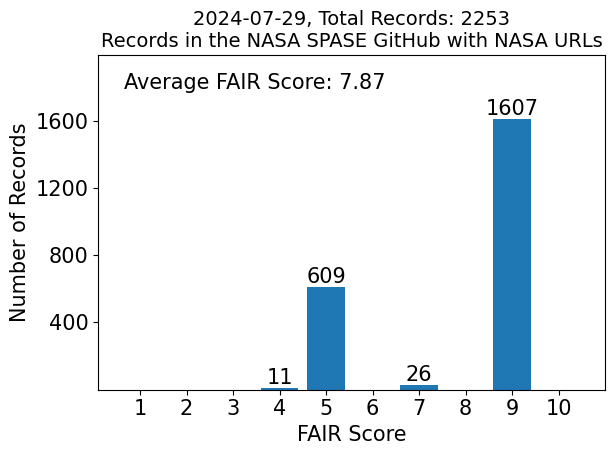

In [21]:
# only for records with NASA URLs
fig = FAIR_Chart(conn, All = False)

## How to do your own queries 
This section gives complex examples of how to query the database for row specific and column specific queries. Also provided are brief explanations of some of the SQLite syntax and also an example of a complex query for both categories. <br>

If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">https://www.sqlitetutorial.net/</a>.<br>

*Disclaimer: Not all authors are provided, as checks were only done to find if an allowed author exists.* 
<br>
**Also note that when a SPASE record has multiple product keys for one URL or multiple URLs in general, each URL/product key gets their own entry into the table. This is why there may be 'duplicate entries' in the database.**

### Record Specific Queries

This section gives a more complex example of how to get data with queries based on records/rows.

In [22]:
from Scripts import execution

help(execution)

Help on function execution in module Scripts.SQLiteFun:

execution(stmt, conn, number='single')
    Connects to the given SQLite database, creates a cursor object,
    and calls the execute method with the stmt argument. The number
    argument has default value of single, which will format the return
    correctly when selecting only one item. Otherwise pass 'multiple'
    as the argument when selecting more than one item. Calls the
    fetchall method to get all rows returned by the statement that was
    executed. This also displays error messages if any arise. Lastly,
    it returns the values of the matching items from the SQLite SELECT
    statement in a list.
    
    :param stmt: A string of the SQLite statement to be executed.
    :type stmt: String
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param number: An string that formats the return based on how many
                    items are being selected.
    :type number: String
 

> Complex example: Selecting multiple items from multiple tables by using the ResourceID

> - Notice we use commas for multiple items and INNER JOINS when it is over multiple tables.

In [23]:
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
rows = execution(f""" SELECT author, MetadataSources.author_source, Records.SPASE_URL 
            FROM MetadataEntries
                INNER JOIN MetadataSources USING (SPASE_id)
                INNER JOIN Records USING (SPASE_id)
            WHERE SPASE_id = '{ID}';""", conn, "multiple")
rows[0]

('spase://SMWG/Person/Vladislav.M.Petrov',
 'NumericalData/ResourceHeader/Contact/PersonID',
 'https://github.com/hpde/NASA/blob/master/NumericalData/Interball-2/IMAP3/PT120S.xml')

### Column Specific Queries
This section describes how to get data with queries based on the column values.

> Ex: How many records have 3 out of 4 fields needed for citation?
> - Use AND and OR operators just like in programming languages.

In [24]:
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM TestResults 
                WHERE (has_author = 1 
                AND has_datasetName = 1
                AND has_pubYr = 1)
                OR (has_author = 1 
                AND has_datasetName = 1
                AND has_pub = 1)
                OR (has_author = 1 
                AND has_pub = 1
                AND has_pubYr = 1)
                OR (has_datasetName = 1 
                AND has_pub = 1
                AND has_pubYr = 1)"""
items = execution(stmt, conn)
items

[2906]

> Complex Ex: What records have at least 2 of the desired fields?
> - Notice we use f-strings to concatenate strings instead of retyping text.

> *Note that you can find more complex SQLite queries such as AL1Stmt, AL3Stmt, and allStmt in the RecordGrabber.py script. Also found here is work for having queries specific to publishers*

In [25]:
has_citation = """author NOT LIKE ""
                    AND datasetName NOT LIKE ""
                    AND publicationYr NOT LIKE ""
                    AND publisher NOT LIKE "" """
citationStmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE {has_citation};"""
has_compliance = """ description NOT LIKE ""
                AND datasetName NOT LIKE ""
                AND PID NOT LIKE "" """
complianceStmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE {has_compliance};"""

# at least 2 fields
AL2Stmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE ({has_citation}
                AND
                    {has_compliance}) 
                OR
                    ({has_citation}
                AND
                    PID NOT LIKE "")
                OR
                    ({has_citation}
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%")
                OR
                    ({has_compliance}
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%")
                OR
                    ({has_compliance}
                AND 
                    PID NOT LIKE "")
                OR  
                    (PID NOT LIKE ""
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%") LIMIT 10;"""

items = execution(AL2Stmt, conn)
items

['spase://NASA/DisplayData/POLAR/VIS/PT300S',
 'spase://NASA/DisplayData/SDO/AIA/SSC/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-A/SECCHI/Cor1/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-A/SECCHI/Cor2/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-A/SECCHI/EUVI/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-B/SECCHI/Cor1/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-B/SECCHI/Cor2/CarringtonMaps',
 'spase://NASA/DisplayData/STEREO-B/SECCHI/EUVI/CarringtonMaps',
 'spase://NASA/DisplayData/UCLA/Global-MHD-code/mS1-Vx/PT10S',
 'spase://NASA/DisplayData/UCLA/Global-MHD-code/mS2-Bz/PT10S']

## How to Backup Database
This code generates a backup copy of the live database into a file specified by the filename variable.

*Note that this cannot be run if there is a pending SQL statement or open transaction running.*

In [26]:
from Scripts import executionALL

help(executionALL)

Help on function executionALL in module Scripts.SQLiteFun:

executionALL(stmt, conn)
    Connects to the given SQLite database, creates a cursor object,
    and calls the execute method with the stmt argument. This also
    displays error messages if any arise.
    
    :param stmt: A string of the SQLite statement to be executed.
    :type stmt: String
    :param conn: A connection to the desired database
    :type conn: Connection object
    :return: None



In [27]:
filename = "../SPASE_Data_new_backup.db"
stmt = f"VACUUM main INTO '{filename}'"
executionALL(stmt, conn)